# Sampling from statistical distributions in Python

If you are working in simulation modelling in Python, you will likely need to use `numpy.random` namespace. It provides a variety of statistical distributions which you can use for efficient sampling. 

This notebook will guide you through examples of 

1.  Creating instances of a high quality Pseudo Random Number Generator (PRNG) using PCG64 provided by `numpy`
2.  Generating samples from the **uniform**, **exponential** and **normal** distributions.
3.  Spawning multiple non-overlapping streams of random numbers
4.  Using OOP to encapsulate PRNGs, distributions and parameters for simulation models.

## 1. Imports

We will import `numpy` for our sampling and `matplotlib` to plot our distributions.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Helper functions

The simple function below can be used to automatically produce a plot illustrating a distribution of samples.   

In [19]:
def distribution_plot(samples, bins=100, figsize=(5,3)):
    '''
    Helper function to visualise the distributions
    
    Params:
    -----
    samples: np.ndarray
        A numpy array of quantitative data to plot as a histogram.
        
    bins: int, optional (default=100)
        The number of bins to include in the histogram
        
    figsize: (int, int) (default=(5,3))
        Size of the plot in pixels
        
    Returns:
    -------
        fig, ax: a tuple containing matplotlib figure and axis objects.
    '''
    hist = np.histogram(samples, bins=np.arange(bins), 
                        density=True)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    _ = ax.plot(hist[0])
    _ = ax.set_ylabel('p(x)')
    _ = ax.set_xlabel('x')
    
    return fig, ax

## 3. Creating a random number generator object

To generate pseudo random numbers for sampling from each distribution, we can use the `default_rng()` function from the `numpy.random` module.

This function constructs an instance of a `Generator` class, which can produce random numbers. 

By default `numpy` uses a Pseudo-Random Number Generator (PRNG) called use of the [Permuted Congruential Generator 64-bit](https://www.pcg-random.org/) (PCG64; period = $2^{128}$; maximum number of streams = $2^{127}$).

For more information on `Generator` you can look at [`numpy` online documentation.](https://numpy.org/doc/stable/reference/random/generator.html)

In [20]:
rng = np.random.default_rng()

In [21]:
type(rng)

numpy.random._generator.Generator

## 4. Steps to create a sample

In general, the approach to sampling is:

1. Create a random number **generator** object

2. Using the object call the method for the **statistical distribution**
    * Each method has its own custom parameters
    * Each method will include a `size` parameter that you use to set the number of samples to generate

3. **Store** the result in an appropriately named variable

### 4.1 Uniform distribution


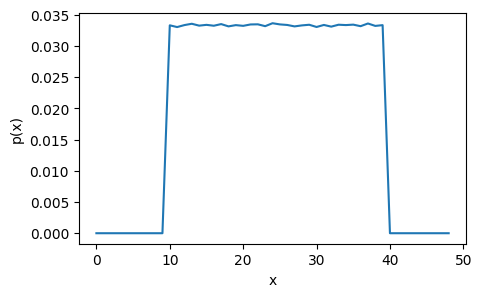

In [22]:
# Step 1: create a random number generator object - set seed to 42
rng = np.random.default_rng(42)

# Step 2 and 3: call the appropriate method of the generator and store result
samples = rng.uniform(low=10, high=40, size=1_000_000)

# Illustrate with plot.
_ = distribution_plot(samples, bins=50)

### 4.2 Exponential distribution

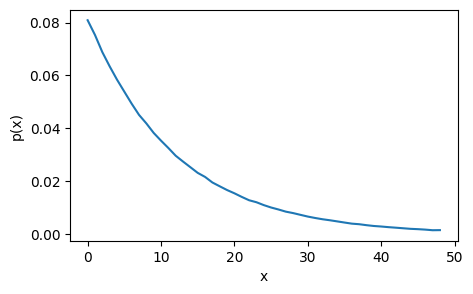

In [23]:
rng = np.random.default_rng(42)
samples = rng.exponential(scale=12, size=1_000_000)
_ = distribution_plot(samples, bins=50)

## 4.3 Normal distribution

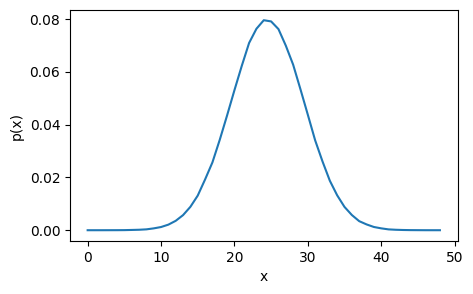

In [24]:
rng = np.random.default_rng(42)
samples = rng.normal(loc=25.0, scale=5.0, size=1_000_000)
_ = distribution_plot(samples, bins=50)

## 4.4 Generating a single sample

If we just need to generate the a single sample we omit the `size` parameter. This returns a scalar value.

In [25]:
rng = np.random.default_rng(42)
sample = rng.normal(loc=25.0, scale=5.0)
print(sample)
print(type(sample))

26.523585398772155
<class 'float'>


**Note** that you can also set `size` to 1.  Just be aware that an array is returned. e.g.

In [26]:
rng = np.random.default_rng(42)
sample = rng.normal(loc=25.0, scale=5.0, size=1)
# a numpy array is returned
print(sample)
print(type(sample))

# to access the scalar value use the 0 index of the array.
print(sample[0])

[26.5235854]
<class 'numpy.ndarray'>
26.523585398772155


## 5. Spawning multiple non-overlapping PRN streams.

For simulation we ideally want to use multiple streams of random numbers that do not overlap (i.e. they are independent). This is straightforward to implement in Python using `SeedSequence` and a user provided integer seed and the number of independent streams to spawn.

> As a user we don't need to worry about the quality of the integer seed provided. This is useful for implementing multiple replications and common random numbers.

Here's how we create the seeds from a single user supplied seed.  The returned variable `seeds` is a Python `List`.

In [27]:
n_streams = 2
user_seed = 1

seed_sequence = np.random.SeedSequence(user_seed)
seeds = seed_sequence.spawn(n_streams)

We use `seeds` when creating our PRNGs.  For example, one for inter-arrival times and one for service times.

In [28]:
# e.g. to model arrival times
arrival_rng = np.random.default_rng(seeds[0])

# e.g. to model service times
service_rng = np.random.default_rng(seeds[1])

## 6. Encapsulating distributions, parameters, and random seeds.

When building a simulation model it is often useful to *package up* both a random number generator, parameters for a specific distribution, and a seed in a **python class**.  This allows **easy creation** of generator objects, straightforward sampling, and improves management of streams for each activity in a simulation model.

As an example below, the class `Exponential` represents the exponential distribution. It accepts a mean value parameter and you can set the random seed.

We will then instantiate two `Exponential` objects for two different processes in our simulation: acute length of stay, and rehab length of stay.

In [29]:
class Exponential:
    '''
    Convenience class for the exponential distribution.
    Packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor

        Params:
        ------
        mean: float
            The mean of the exponential distribution

        random_seed: int | SeedSequence, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean

    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution

        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)

In [30]:
acute_los = Exponential(3.0, random_seed=42)
rehab_los = Exponential(30.0, random_seed=101)

In [31]:
acute_los.sample()

7.2126258118979845

In [32]:
rehab_los.sample()

122.69065518352762

## 7. Next steps

We can now move onto creating simple Discrete-Event Simulation models using `simpy` models that make use of `numpy` sampling.